In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

from test_sampler import TestProblem, TestProblem2

## Test problem choice

In [5]:
test_problem = TestProblem(gamma=1e-4, svxpy_verbose=False)

In [3]:
test_problem = TestProblem2(La=1000, Lb=10)

## ACRCD

In [4]:
# ACRCD


# y (paper) = q(code_)
def ACRCD(test_problem, x_0, y_0, K, L1_init=1000, L2_init=1000):
    history = []
    grad_x_norms = []
    grad_y_norms = []

    L1 = L1_init
    L2 = L2_init

    beta = 1 / 2

    x_list = [x_0]
    y_list = [y_0]
    z1_cur = x_0
    z2_cur = y_0
    q1_cur = x_0
    q2_cur = y_0

    n_ = L1 ** beta + L2 ** beta

    # q_cur_block (code) = y (paper)
    # z_cur_block (code) = z (paper)
    for i in tqdm(range(K)):

        #####  redefine alpha, tau
        alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)

        x1_upd = tau * z1_cur + (1 - tau) * q1_cur
        x2_upd = tau * z2_cur + (1 - tau) * q2_cur

        result, grad_x, grad_y = test_problem.calc(x1_upd, x2_upd)
        history.append(result.item())

        # h1.append(test_problem.f1(x1_upd, x2_upd).item())
        # h2.append(test_problem.f2(x1_upd).item())

        grad_x_norms.append(np.linalg.norm(grad_x))
        grad_y_norms.append(np.linalg.norm(grad_y))

        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])

        if index_p == 0:
            q1_upd = x1_upd - (1 / L1) * grad_x
            q2_upd = q2_cur

            z1_upd = z1_cur - (1 / L1) * alpha * n_ * grad_x
            z2_upd = z2_cur


        if index_p == 1:
            q1_upd = q1_cur
            q2_upd = x2_upd - (1 / L2) * grad_y

            z1_upd = z1_cur
            z2_upd = z2_cur - (1 / L2) * alpha * n_ * grad_y

        x_list.append(x1_upd)
        y_list.append(x2_upd)

        z1_cur = z1_upd
        z2_cur = z2_upd

        q1_cur = q1_upd
        q2_cur = q2_upd

    return history, grad_x_norms, grad_y_norms, x_list, y_list, [L1, L2]

In [5]:
def test_algo_by_problem(test_problem, algo_func, k=5000, L1_init=100, L2_init=100):
    x0 = np.zeros(test_problem.x_dim)
    y0 = np.zeros(test_problem.y_dim)

    history, grad_x_norms, grad_y_norms, x1_list_ACRCD, x2_list_ACRCD, (L1, L2) = \
        algo_func(test_problem,x0, y0, K=k, L1_init=L1_init, L2_init=L2_init)
    res_f, grad_x, grad_y = test_problem.calc(x1_list_ACRCD[-1], x2_list_ACRCD[-1])

    print("start f val: ", history[0])
    print("result val: ", res_f)
    print("grad x norm: ", np.linalg.norm(grad_x))
    print("grad y norm: ", np.linalg.norm(grad_y))
    print("solver/analytic f*: ", test_problem.f_star)
    print("start, end L1: ", L1_init, L1)
    print("start, end L2: ", L2_init, L2)

    plt.plot(grad_x_norms, label='x grad norm')
    plt.plot(grad_y_norms, label='y grad norm')
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.plot(history, label="func_value")
    plt.show()

In [6]:
test_problem = TestProblem2(La=1000, Lb=10)

100%|██████████| 10000/10000 [00:03<00:00, 2502.06it/s]


start f val:  0.0
result val:  -1942.1281782676272
grad x norm:  0.6073764859685967
grad y norm:  0.5355188534193593
solver/analytic f*:  -1974.9124619978093
start, end L1:  1000 1000
start, end L2:  10 10


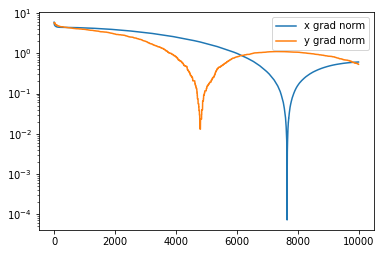

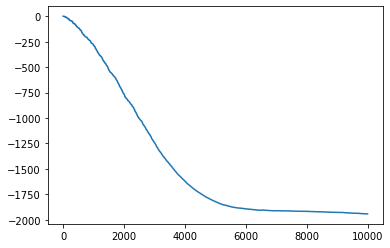

In [7]:
test_algo_by_problem(test_problem, algo_func=ACRCD, L1_init=test_problem.La, L2_init=test_problem.Lb, k=10000)

100%|██████████| 5000/5000 [00:03<00:00, 1636.51it/s]


start f val:  0.0
result val:  1.0773263720427069e+130
grad x norm:  4.641823719278248e+66
grad y norm:  1.0023595740212734
solver/analytic f*:  -1829.0170132150374
start, end L1:  500.0 500.0
start, end L2:  10 10


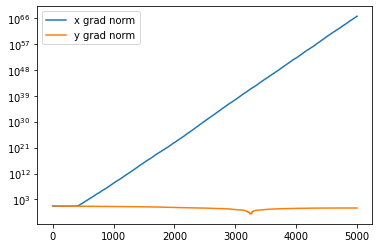

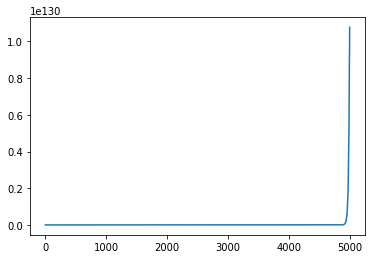

In [21]:
test_algo_by_problem(test_problem, algo_func=ACRCD, L1_init=test_problem.La/2, L2_init=test_problem.Lb)

In [14]:
# y (paper) = q(code_)

def ACRCD_star(test_problem, x1_0, x2_0, K, L1_init=5000, L2_init=5000):
    ADAPTIVE_DELTA = 1e-8

    history = []
    grad_x1_norms = []
    grad_x2_norms = []

    x1_list = [x1_0]
    x2_list = [x2_0]

    z1 = y1 = x1_0
    z2 = y2 = x2_0

    L1 = L1_init
    L2 = L2_init
    beta = 1 / 2

    for i in tqdm(range(K)):
        tau = 2 / (i + 2)

        x1 = tau * z1 + (1 - tau) * y1
        x2 = tau * z2 + (1 - tau) * y2

        res_x, *gradients_x = test_problem.calc(x1, x2) # moved out of the inner loop
        history.append(res_x.item())
        grad_x1_norms.append(np.linalg.norm(gradients_x[0]).item())
        grad_x2_norms.append(np.linalg.norm(gradients_x[1]).item())

        n_ = L1 ** beta + L2 ** beta
        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])
        Ls = [L1, L2]
        Ls[index_p] /= 2

        # ADAPTIVE

        inequal_is_true = False
        xs = [x1, x2]
        sampled_gradient_x = gradients_x[index_p]

        for j in range(100):
            if index_p == 0:
                y1 = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
                y2 = x2
            else:
                y2 = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
                y1 = x1
                
            res_y, *_ = test_problem.calc(y1, y2)
                
            inequal_is_true = 1 / (2 * Ls[index_p]) * np.linalg.norm(sampled_gradient_x) ** 2 <= res_x - res_y + ADAPTIVE_DELTA
            if inequal_is_true: break
            Ls[index_p] *= 2

        L1, L2 = Ls
        n_ = L1 ** beta + L2 ** beta
        alpha = (i + 2) / (2 * n_ ** 2)

        if index_p == 0:
            z1 = z1 - (1 / L1) * alpha * n_ * sampled_gradient_x

        if index_p == 1:
            z2 = z2 - (1 / L2) * alpha * n_ * sampled_gradient_x

        x1_list.append(x1)
        x2_list.append(x2)

    return history, grad_x1_norms, grad_x2_norms, x1_list, x2_list, [L1, L2]



100%|██████████| 5000/5000 [00:07<00:00, 663.33it/s]


start f val:  0.0
result val:  -1823.437047769632
grad x norm:  0.32851266254191597
grad y norm:  0.17589029365889647
solver/analytic f*:  -1829.0170132150374
start, end L1:  1000 250.0
start, end L2:  10 2.5


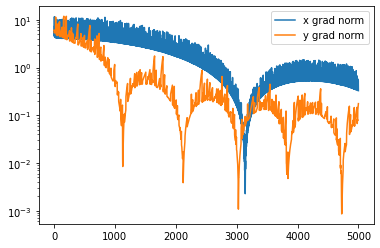

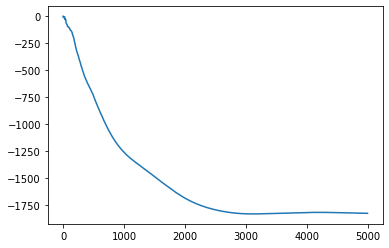

In [15]:
test_algo_by_problem(test_problem, algo_func=ACRCD_star, L1_init=test_problem.La, L2_init=test_problem.Lb)

100%|██████████| 5000/5000 [00:07<00:00, 669.14it/s]


start f val:  0.0
result val:  -1824.0271390939947
grad x norm:  0.3201181718185787
grad y norm:  0.026403532833113044
solver/analytic f*:  -1829.0170132150374
start, end L1:  500.0 250.0
start, end L2:  10 10.0


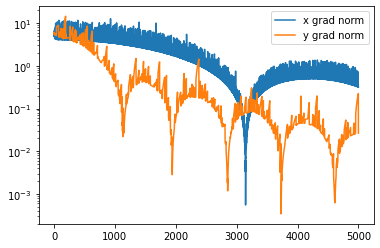

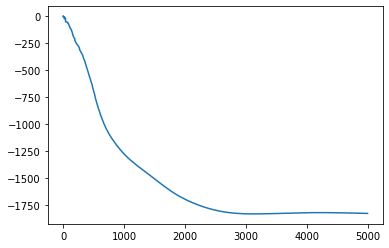

In [16]:
test_algo_by_problem(test_problem, algo_func=ACRCD_star, L1_init=test_problem.La/2, L2_init=test_problem.Lb)